# Convolutional Neural Networks for Hand SIGN Prediction

The purpose of this project is to predict the hand sign using convolutional neural networks (CNN) architecture. First, 'vanilla' CNN, i.e CNN without any hyperparameter or regularization tuning, will be applied and the corresponding accuracy to predict the training set will be investigated. Then, different kinds of regularization technique will be applied to see the difference in accuracy compared to vanilla CNN.

The dataset consists of 1200 images of hand sign indicates the number of 0 until 5. The visualization of the image can be seen shortly. So let's import the libraries that we will need.

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

Next, we need to define the function to load the dataset. The dataset is already available in h5 format. Hence, all we need to do is just read the h5 format using the h5py library that has been imported already and convert the pixel value into numpy array.

In [27]:
def load_dataset():
    
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:]) 
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

Next, load the data which consists of training set and test set using the function defined above.

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [29]:
print('The shape of training set is:'+str(X_train_orig.shape))
print('The shape of test set is:'+str(X_test_orig.shape))

The shape of training set is:(1080, 64, 64, 3)
The shape of test set is:(120, 64, 64, 3)


As we can see above, the shape of the training set is (1080, 64, 64, 3), which means that there are 1080 training examples, which each training image has a 64 x 64 pixels with RGB color channel. Meanwhile, the test set has 120 examples and each image has the same properties as the training image.

Now, let's visualize some of the images in the training set.

In [32]:
def visualizeSign(xData, index):
    
    plt.figure(figsize=(12,5))
    
    for i in range (len(index)):
        
        matrixData = xData[index[i]]
        
        plt.subplot(3,7,i+1)
        plt.imshow(matrixData)
        plt.axis('off')

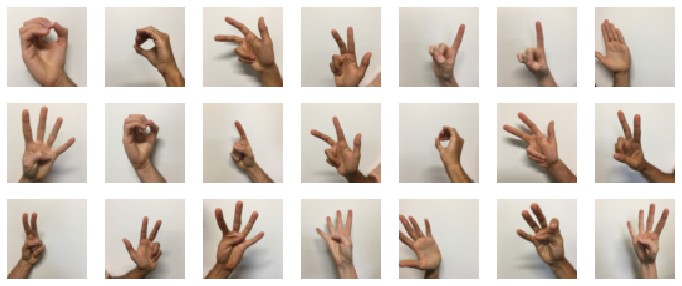

In [33]:
index = [1,50,100,150,200,250,300,350,400,450,500,550,25,75,125,175,225,275,325,375,425]
visualizeSign(X_train_orig, index)

We can see the visualization of the image used in the training set above. Each of the hand sign corresponds to certain label $Y$, which has the range between 0 until 5. Before we create a model in order to train neural networks to predict $Y$, first we need to convert the $Y$ value from sparse categorical to its one-hot encoding representation. So, let's define a function to do that. 

In [34]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [35]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

In [36]:
Y_train

array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

Now we have the one-hot encoding representation of the response value $Y$. One step before building the neural network model, we need to define the so-called callbacks function so that at the time we train the neural networks model, only the loss and accuracy in certain epochs will be printed. This will be beneficial to save some spaces and not bloating out the notebook with the full output results.

In [71]:
class LossAndMetricCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        if epoch %20 ==0:
            print('\n After epochs {}, the loss is {:7.2f}, with accuracy {:7.2f}'
                  .format(epoch, logs['loss'], logs['accuracy']))

## Vanilla Convolutional Model

In this section, the so-called vanilla CNN model will be built. It's called vanilla because there will be no additional technique in order to tweak or tune the model, so it's just pure model. In overview, below is the detailed architecture of this convolutional neural networks model.

<img src="CNN.png" width="700" height="200">

Next, let's import additional library that we will need to build the model.

In [79]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D

Next, define an architecture of the model based on the illustration above.

In [80]:
def get_vanilla_model(input_shape):

    inputs = Input(shape=input_shape)
    A1 = Conv2D(16, (3,3), padding='SAME', activation='relu')(inputs)
    P1 = MaxPooling2D((3,3))(A1)
    A2 = Conv2D(32, (3,3), padding='SAME', activation='relu')(P1)
    P1 = MaxPooling2D((3,3))(A2)
    F = Flatten()(P1)
    FC = Dense(100, activation='relu')(F)
    FC = Dense(20, activation='relu')(FC)
    outputs = Dense(6, activation='softmax')(FC)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

Call the function above to create the model.

In [81]:
model = get_vanilla_model(X_train[0,:,:,:].shape)

Next, let's compile the model. As the optimization algorithm, we will use Adam optimizer. To define the cost function, we use `categorical_crossentropy` due to the fact that we have 6 possible outputs and we use softmax layer as the output layers. As the metrics, we will use the standard metrics for classification problem, which is the accuracy.

In [82]:
model.compile(optimizer='adam',
             loss ='categorical_crossentropy',
             metrics=['accuracy'])

After compiling the model, next it is the time to train the convolutional neural network model. There will be in total 100 epochs or training loops, with the batch size = 128 to run mini-batch gradient descent with Adam optimizer. Finally, the callback function that already defined in advance will also be called in order to supress the output into only every 20 epochs.

In [83]:
history = model.fit(X_train, Y_train, epochs=101, batch_size=128, 
                    callbacks=[LossAndMetricCallback()], verbose=False)


 After epochs 0, the loss is    1.80, with accuracy    0.17

 After epochs 20, the loss is    0.41, with accuracy    0.87

 After epochs 40, the loss is    0.13, with accuracy    0.97

 After epochs 60, the loss is    0.04, with accuracy    1.00

 After epochs 80, the loss is    0.01, with accuracy    1.00

 After epochs 100, the loss is    0.01, with accuracy    1.00


As we can see from the training result above, at epochs 0, the accuracy is 0.17, which means the model is the same as when we random guessing out of 6 possibilities. At the epochs 100, the loss is 0 and the accuracy is 100%, which means the model can predict all of the input images perfectly.

Next, let's visualize the learning curve of the model.

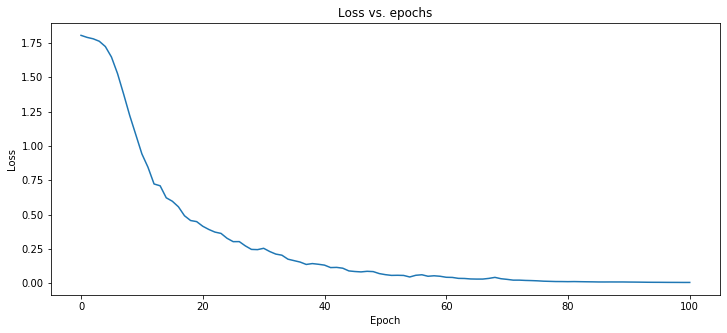

In [84]:
fig = plt.figure(figsize=(12, 5))

plt.plot(history.history['loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Finally, let's evaluate our model with the test set.

In [87]:
model.evaluate(X_test,Y_test)

4/4 [==============================] - 0s 7ms/step - loss: 0.2240 - accuracy: 0.9333


[0.22395826876163483, 0.9333333373069763]

The accuracy of the vanilla CNN model in the test set is 93.33%. Although this is pretty good, but we can see that the vanilla model suffers from variance model, in which the model clearly overfits the training data and cannot generalizing the test data well enough.

Let's see if we can improve the accuracy in the test set with regularization technique.

## Regularized Model

In this section, the vanilla model that alrady defined above will be slightly modified. The only modification is the addition of regularization term in between the dense, fully connected layers before the output layer.

The regularization term that will be applied is L2 regularization, and the value will be set to 0.001, which I think will be enough to penalize the weight in the fully connected layer. Let's define a function to define the regularized model.

In [93]:
def get_regularized_model(input_shape):
    
    inputs = Input(shape=input_shape)
    A1 = Conv2D(16, (3,3), padding='SAME', activation='relu')(inputs)
    P1 = MaxPooling2D((3,3))(A1)
    A2 = Conv2D(32, (3,3), padding='SAME', activation='relu')(P1)
    P1 = MaxPooling2D((3,3))(A2)
    F = Flatten()(P1)
    FC = Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(F)
    FC = Dense(20, activation='relu')(FC)
    outputs = Dense(6, activation='softmax')(FC)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

Next, let's call the function above.

In [94]:
model_w_regularization = get_regularized_model(X_train[0,:,:,:].shape)

And the compile the model with the same setup that we used in the vanilla CNN model.

In [95]:
model_w_regularization.compile(optimizer='adam',
             loss ='categorical_crossentropy',
             metrics=['accuracy'])

Finally, we can train the regularized model and see how it performs.

In [96]:
history_regularization = model_w_regularization.fit(X_train, Y_train, epochs=101, batch_size=128, 
                                                   callbacks=[LossAndMetricCallback()], verbose=False)


 After epochs 0, the loss is    1.96, with accuracy    0.16

 After epochs 20, the loss is    0.58, with accuracy    0.82

 After epochs 40, the loss is    0.25, with accuracy    0.96

 After epochs 60, the loss is    0.14, with accuracy    0.99

 After epochs 80, the loss is    0.10, with accuracy    1.00

 After epochs 100, the loss is    0.08, with accuracy    1.00


Same as the one in the original model, our model starts with accuracy of 16%, which is roughly equal to the percentage of random guessing of 6 outcome possibilities. At epochs 100, the accuracy is also 100% but let's see if in the test set, the performance in the test set is improved.

Let's visualize the learning curve of the regularized model first.

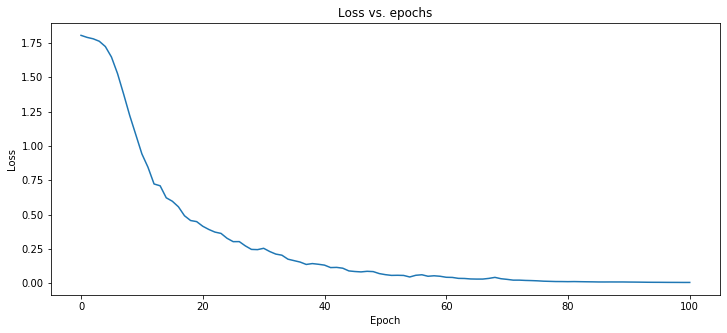

In [97]:
fig = plt.figure(figsize=(12, 5))

plt.plot(history.history['loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Finally, let's evaluate the model.

In [98]:
model_w_regularization.evaluate(X_test,Y_test)

4/4 [==============================] - 0s 7ms/step - loss: 0.2606 - accuracy: 0.9417


[0.26055029034614563, 0.9416666626930237]

From the result above, we can see that there is slight improvement on the test set performance for the regularized model compared to vanilla model. The improvement is pretty small, which only roughly 0.8%. Let's see if we can improve the performance using other regularization technique.

## Batch Normalization Model

In this section, we will apply the other regularization technique other than L2, which is batch normalization. The intuition behind batch normalization is that we normalize the value in the hidden units in every batch to add some noise into the model and hence, it will be helpful to prevent overfitting.

The batch normalization will be applied in one of the fully connection layer, after we flattened the convolutional layers. In order to apply this normalization, we need to import the necessary library in keras API.

In [101]:
from tensorflow.keras.layers import BatchNormalization

Next, let's define a function same as before to initialize the model with batch normalization assigned.

In [102]:
def get_batchnorm_model(input_shape):
    
    inputs = Input(shape=input_shape)
    A1 = Conv2D(16, (3,3), padding='SAME', activation='relu')(inputs)
    P1 = MaxPooling2D((3,3))(A1)
    A2 = Conv2D(32, (3,3), padding='SAME', activation='relu')(P1)
    P1 = MaxPooling2D((3,3))(A2)
    F = Flatten()(P1)
    FC = Dense(100, activation='relu')(F)
    FC = BatchNormalization()(FC)
    FC = Dense(20, activation='relu')(FC)
    outputs = Dense(6, activation='softmax')(FC)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

Let's call the function that we just defined above.

In [103]:
model_w_batchnorm = get_batchnorm_model(X_train[0,:,:,:].shape)

Then, compile the model with the same setup that already defined in the previous model.

In [104]:
model_w_batchnorm.compile(optimizer='adam',
             loss ='categorical_crossentropy',
             metrics=['accuracy'])

And train the model with batch normalization technique and let's see how it performs.

In [106]:
history_batchnorm = model_w_batchnorm.fit(X_train, Y_train, epochs=101, batch_size=128,
                                         callbacks=[LossAndMetricCallback()], verbose=False)


 After epochs 0, the loss is    1.58, with accuracy    0.35

 After epochs 20, the loss is    0.01, with accuracy    1.00

 After epochs 40, the loss is    0.00, with accuracy    1.00

 After epochs 60, the loss is    0.00, with accuracy    1.00

 After epochs 80, the loss is    0.00, with accuracy    1.00

 After epochs 100, the loss is    0.00, with accuracy    1.00


As we can see from the training result, the model with batch normalization is really fast to reach the accuracy of 100% compared to the other model before. However, we need to check the performance in the test set later. Let's visualize the learning curve first.

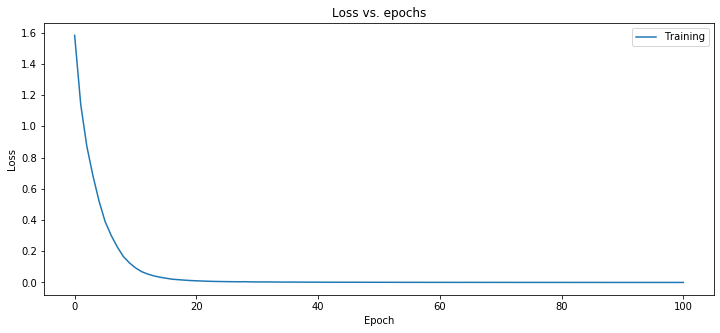

In [107]:
fig = plt.figure(figsize=(12, 5))

plt.plot(history_batchnorm.history['loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

And let's evaluate the performance of the model in the test set..

In [108]:
model_w_batchnorm.evaluate(X_test,Y_test)

4/4 [==============================] - 0s 7ms/step - loss: 0.1589 - accuracy: 0.9583


[0.1589217185974121, 0.9583333134651184]

As we can see from the learning curve and the performance in the test set above, the addition of batch normalization in the model massively improve the convergence speed of the training process as well as the ability to generalize in the test set. For the performance in the test set, the improvement is about 1.7% compared to the same model with L2 regularization. Next, let's see how the model with dropout regularization performs. 

## Dropout Model

In this section, another regularization technique will applied, which is dropout regularization. The intuition behind dropout regularization is to drop some of the hidden inputs in a hidden layer randomly following Bernoulli distribution. 

The drpout regularization will be applied in one of the fully connected layers after we flattened the convolutional layers. The dropout rate is 0.3, which means that there are max 30% of the hidden units in a hidden layer will be dropped to reduce the complexity in the dense layer and hence, it will be helpful to reduce overfitting. 

Let's import the necessary library for dropout.

In [109]:
from tensorflow.keras.layers import Dropout

Next, let's define a function to initialize the model with dropout regularization.

In [111]:
def get_dropout_model(input_shape):
    
    inputs = Input(shape=input_shape)
    A1 = Conv2D(16, (3,3), padding='SAME', activation='relu')(inputs)
    P1 = MaxPooling2D((3,3))(A1)
    A2 = Conv2D(32, (3,3), padding='SAME', activation='relu')(P1)
    P1 = MaxPooling2D((3,3))(A2)
    F = Flatten()(P1)
    FC = Dense(100, activation='relu')(F)
    FC = Dropout(0.3)(FC)
    FC = Dense(20, activation='relu')(FC)
    outputs = Dense(6, activation='softmax')(FC)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

Next, initialize the dropout model.

In [116]:
model_w_dropout = get_dropout_model(X_train[0,:,:,:].shape)

And compile the model with the same setup with previous models.

In [117]:
model_w_dropout.compile(optimizer='adam',
             loss ='categorical_crossentropy',
             metrics=['accuracy'])

Finally, let's train the dropout model and see how it performs.

In [118]:
history_dropout = model_w_dropout.fit(X_train, Y_train, epochs=101, batch_size=128,
                                     callbacks=[LossAndMetricCallback()], verbose=False)


 After epochs 0, the loss is    1.80, with accuracy    0.15

 After epochs 20, the loss is    0.49, with accuracy    0.82

 After epochs 40, the loss is    0.20, with accuracy    0.94

 After epochs 60, the loss is    0.11, with accuracy    0.97

 After epochs 80, the loss is    0.04, with accuracy    0.99

 After epochs 100, the loss is    0.03, with accuracy    0.99


As we can see above, at the end of training epochs, the model is able to achieve 99% accuracy, with the loss of 0.03. However, as we can see from the other model, superior performance in the training set is not a guarantee that the model will also perform well in the test set. Before we evaluate the model, let's visualize the learning curve.

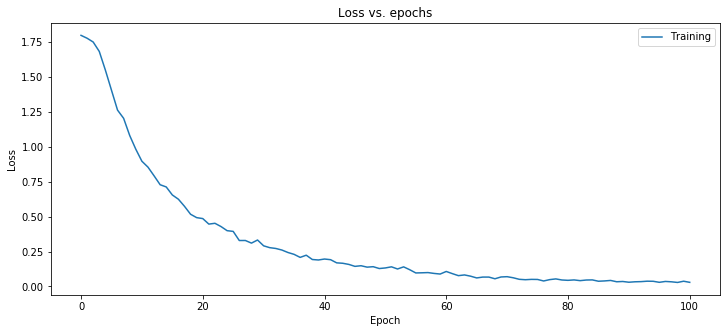

In [119]:
fig = plt.figure(figsize=(12, 5))

plt.plot(history_dropout.history['loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

And finally we can evaluate the model performance on the test set..

In [120]:
model_w_dropout.evaluate(X_test,Y_test)

4/4 [==============================] - 0s 7ms/step - loss: 0.1643 - accuracy: 0.9417


[0.1642770916223526, 0.9416666626930237]

As we can see above, the performance of the dropout model is 94.1%, which is slightly less than the one we got with the model with batch normalization. Next, let's summarize the performance of the model and then pick the best model in terms of their performance in the test set and use it to predict the hand sign taken from my own phone camera!

## Model Performance Summary

In this section, all of the models that have been applied above will be compared in a table summary. Below is the table summary on how the same model with different regularization performed in the training set and the test set.


| Model         | Training (% Accuracy) | Test (% Accuracy)      |
|--------------------|----------|-----------|
| Vanilla     | 100   | 93.3    |
| L2 Regularization               | 100    | 94.1    | 
| Batch Normalization| 100   | 95.8     |
| Dropout Regularization        | 99    | 94.1     | 

From the summary above, we can conclude that the model with batch normalization performed better than any of the other model in the test set. Hence, let's use this model in order to predict the hand sign taken from my phone camera.

## Prediction Using Batch Normalization Model

Now that we know how each of the model with different regularization performs, now it's time to make some predictions based on out-of-sample images, which was taken from my phone camera. The model used to predict the images is the model with batch normalization.

Before we make some predictions, let's define a function to read the image into numpy array, and then resize the image into 64 x 64 pixels according to the input shape of our CNN model. The library OpenCV will be used for this purpose.

In [376]:
import cv2

def import_and_resize(image_data):
    
    img = cv2.imread(image_data)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img_resize = (cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_CUBIC))/255.
    
    return img_resize

### Prediction 1

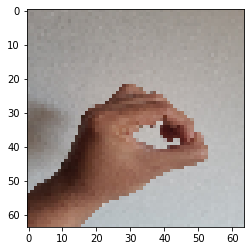

In [379]:
image_1 = import_and_resize('sign_1.jpg')
image_1_reshape = image_1[np.newaxis,...]
plt.imshow(image_1)

Next, we can check the prediction from our model..

In [381]:
prediction = np.argmax(model_w_batchnorm.predict(image_1_reshape))
print('The model predicts that it is: '+ str(prediction))

The model predicts that it is: 0


As we can see above, the model predicts the correct answer for this case

### Prediction 2

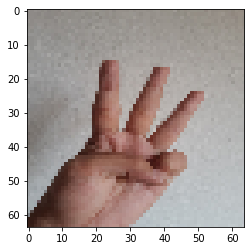

In [390]:
image_2 = import_and_resize('sign_2.jpg')
image_2_reshape = image_2[np.newaxis,...]
plt.imshow(image_2)

In [392]:
prediction = np.argmax(model_w_batchnorm.predict(image_2_reshape))
print('The model predicts that it is: '+ str(prediction))

The model predicts that it is: 3


### Prediction 3

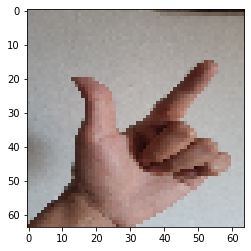

In [393]:
image_3 = import_and_resize('sign_3.jpg')
image_3_reshape = image_3[np.newaxis,...]
plt.imshow(image_3)

In [395]:
prediction = np.argmax(model_w_batchnorm.predict(image_3_reshape))
print('The model predicts that it is: '+ str(prediction))

The model predicts that it is: 3


### Prediction 4

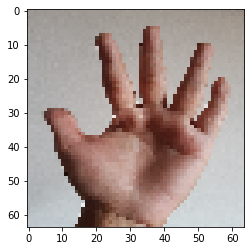

In [396]:
image_4 = import_and_resize('sign_4.jpg')
image_4_reshape = image_4[np.newaxis,...]
plt.imshow(image_4)

In [397]:
prediction = np.argmax(model_w_batchnorm.predict(image_4_reshape))
print('The model predicts that it is: '+ str(prediction))

The model predicts that it is: 5


### Prediction 5

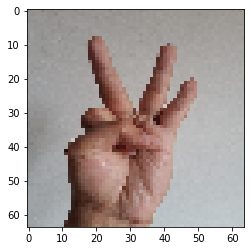

In [398]:
image_5 = import_and_resize('sign_5.jpg')
image_5_reshape = image_5[np.newaxis,...]
plt.imshow(image_5)

In [399]:
prediction = np.argmax(model_w_batchnorm.predict(image_5_reshape))
print('The model predicts that it is: '+ str(prediction))

The model predicts that it is: 3


### Prediction 6

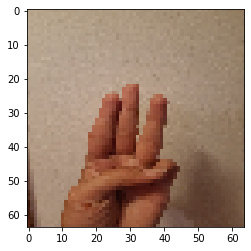

In [400]:
image_6 = import_and_resize('sign_6.jpg')
image_6_reshape = image_6[np.newaxis,...]
plt.imshow(image_6)

In [401]:
prediction = np.argmax(model_w_batchnorm.predict(image_6_reshape))
print('The model predicts that it is: '+ str(prediction))

The model predicts that it is: 3


### Prediction 7

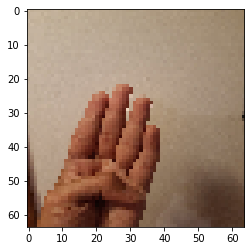

In [402]:
image_7 = import_and_resize('sign_7.jpg')
image_7_reshape = image_7[np.newaxis,...]
plt.imshow(image_7)

In [403]:
prediction = np.argmax(model_w_batchnorm.predict(image_7_reshape))
print('The model predicts that it is: '+ str(prediction))

The model predicts that it is: 3


### Prediction 8

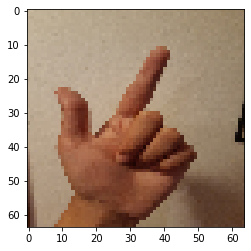

In [404]:
image_8 = import_and_resize('sign_8.jpg')
image_8_reshape = image_8[np.newaxis,...]
plt.imshow(image_8)

In [405]:
prediction = np.argmax(model_w_batchnorm.predict(image_8_reshape))
print('The model predicts that it is: '+ str(prediction))

The model predicts that it is: 3


From the prediction above, we can see that the model performs reasonably well if we give an image input that is similar with what the model see in the training set, i.e hand sign with white background and good amount of light. It is important to note that the dataset that was used for this project is very small for image classification problems. The performance of the model will be greatly improved if we have more training data.

Also, the model performs poorly when the input image has a different light source as the one in the training. As we can see above, when the background and hand colors are blending due to lighting condition, the model couldn't predict well enough. In order to solve this, more training data is needed, especially hand signs with different lighting conditions.